# Import library and sorce codes

## Import library

In [1]:
import pandas as pd
from pymatgen import core
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
import matplotlib.pyplot as plt


## Import sorce codes

In [2]:
import src.preprocess_func as preprocess
import src.training_model as training
import src.plotting as plotting
import src.Variable_generator as vg

# Preprocess data

In [3]:
# filename = 'https://drive.google.com/uc?id=1-2Ia30pDDiRgof0FFinN4EQ-1BN24qld&export=download'
filename = 'srf/SM_FT_dataset.csv'
df = pd.read_csv(filename,index_col=0)

comps = [core.Composition(x) for x in df['Composition']]
dset = preprocess.data_generator(comps)
Training_sequences = dset.real_data # X_train
Elements_sequences = dset.elements #input elements sequence

properties_values = df.iloc[:,1:].values.astype('float32') # Y_train
scaler = StandardScaler() # Standard_scaler
properties_values_scaled = scaler.fit_transform(properties_values) # Scaled Y_train


## Training surrogate model (ANN)

In [4]:
surrogate_model=training.training_surrogate_ANN(Training_sequences,properties_values_scaled)

  0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 100, Loss:0.9563140869140625
epoch: 200, Loss:0.6924842000007629
epoch: 300, Loss:0.5647009611129761
epoch: 400, Loss:0.48822805285453796
epoch: 500, Loss:0.41631317138671875
epoch: 600, Loss:0.3395410478115082
epoch: 700, Loss:0.15002840757369995
epoch: 800, Loss:0.006135506555438042
epoch: 900, Loss:0.002149138366803527
epoch: 1000, Loss:0.0014467842411249876
epoch: 1100, Loss:0.0012415238888934255
epoch: 1200, Loss:0.0011607343330979347
epoch: 1300, Loss:0.0011235523270443082
epoch: 1400, Loss:0.001107232877984643
epoch: 1500, Loss:0.0011000452795997262
epoch: 1600, Loss:0.001098155160434544
epoch: 1700, Loss:0.0010978998616337776
epoch: 1800, Loss:0.0010959422215819359
epoch: 1900, Loss:0.0010956175392493606
epoch: 2000, Loss:0.0010957977501675487
******Training ANN completed*****


## Training conditional autoencoder

In [5]:
cAE=training.training_cAE(Training_sequences,properties_values_scaled)

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 100, Loss:0.005570168606936932
epoch: 200, Loss:0.0030734522733837366
epoch: 300, Loss:0.0015586077934131026
epoch: 400, Loss:0.0009203122463077307
epoch: 500, Loss:0.000711353262886405
epoch: 600, Loss:0.000592061085626483
epoch: 700, Loss:0.0005130895879119635
epoch: 800, Loss:0.00044818170135840774
epoch: 900, Loss:0.0004015045124106109
epoch: 1000, Loss:0.00036028653266839683
*****Training cAE completed*****


# Plotting results

In [6]:
def store_fig(fig,name):
    fig.savefig('Sample_figure/{}.pdf'.format(name))
def store_fig_png(fig,name):
    fig.savefig('Sample_figure\{}.png'.format(name))


## Input scatter

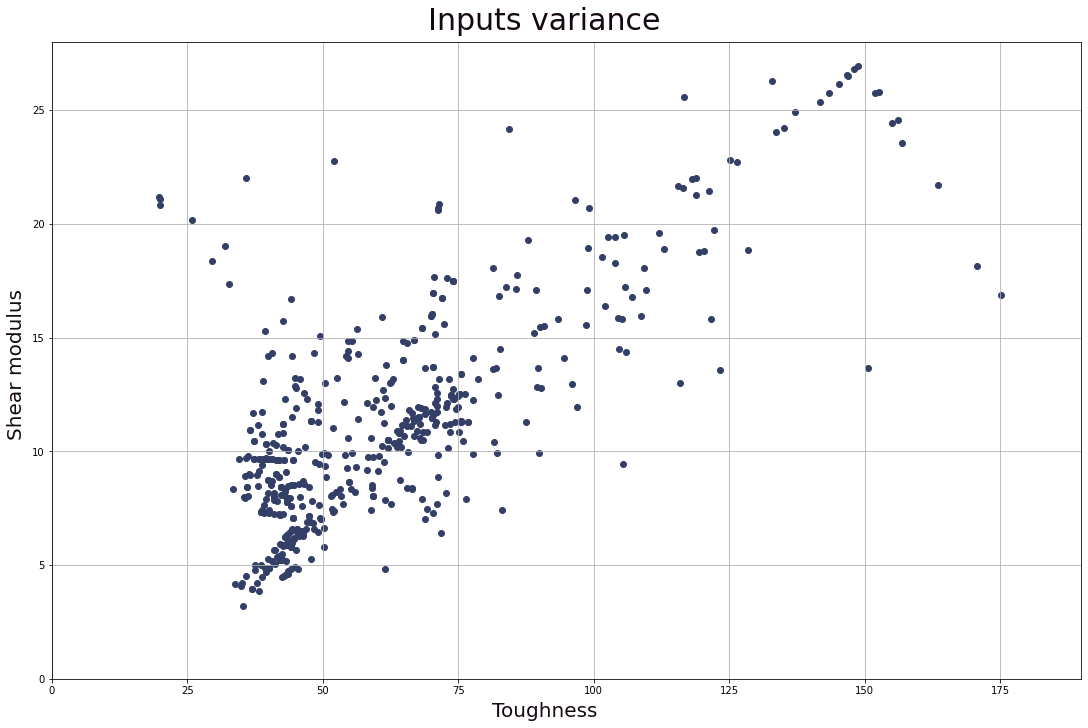

In [7]:
scatter_plot = plotting.input_scatter_plot(properties_values)

## Input distribution

In [21]:
import matplotlib.colors
colorformat = {
    "background":"#FFFFFF",
    "text":"#140812",
    "Highlight":"#730000",
    "bar":"#333F67",
    "line":"#223542"
    }
order=[
    "First",
    "Second",
    "Third",
    "Forth",
    "Fifth",
    "Sixth",
    "Seventh",
    "Eighth",
    "Ninth",
    "Tenth"
]
grid_style = (0, (5, 5))

cmap_format = matplotlib.colors.LinearSegmentedColormap.from_list("",[colorformat["background"],colorformat["bar"]])


In [9]:
def component_variance_plot(Xt,dset,size=1,interval = 28):
    fig,axes = plt.subplots(5*size,1,figsize=(15,5*size))
    fig.set_facecolor(colorformat["background"])
    minor_tick = np.arange(0.5,22.5,1)
    major_tick = np.arange(0,22,1)
    for i in range(5*size):
        im = axes[i].imshow(Xt[interval*i].reshape(1,-1),cmap = cmap_format,vmin=0,vmax=0.6)
        axes[i].set_xticks(major_tick)
        axes[i].set_xticklabels(dset.elements)
        axes[i].set_yticklabels("")
        axes[i].tick_params(axis="both",length=0)
        axes[i].set_xticks(minor_tick,minor=True)
        axes[i].grid(axis = "x",visible=True,which="minor",c=colorformat["line"],linestyle=(0, (5, 5)))
    fig.suptitle("Inputs sequence examples",color=colorformat["text"],fontsize=20*size)
    fig.supxlabel("Concentration of elements",color=colorformat["text"],fontsize=15*size)
    plt.colorbar(im,ax=axes.ravel().tolist())
    return fig

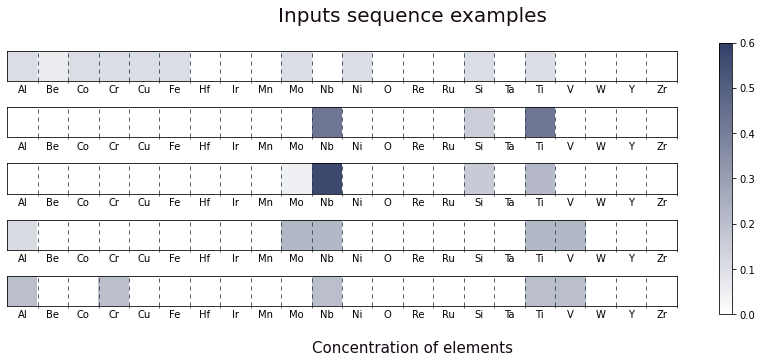

In [10]:
dis_plot = component_variance_plot(Training_sequences,dset)
# store_fig(dis_plot,"input distribution examples")

## Latent space exploration

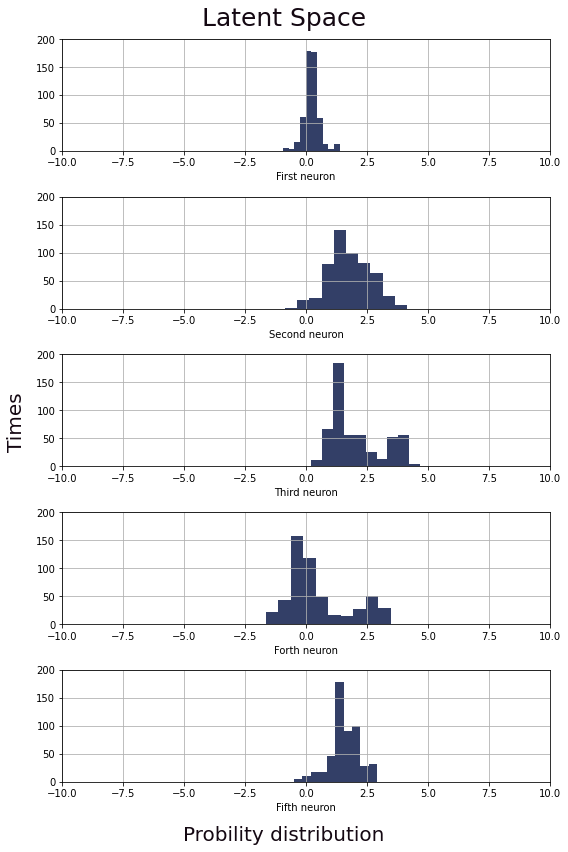

In [11]:
latent_min_Max_collection_cAE,latent_mean_std_collection_cAE,latent_code_cAE=vg.latent_code_inspector_cAE(cAE,Training_sequences,properties_values_scaled)
variance_plot_cAE=plotting.latent_code_variance(latent_code_cAE)

## Mapping

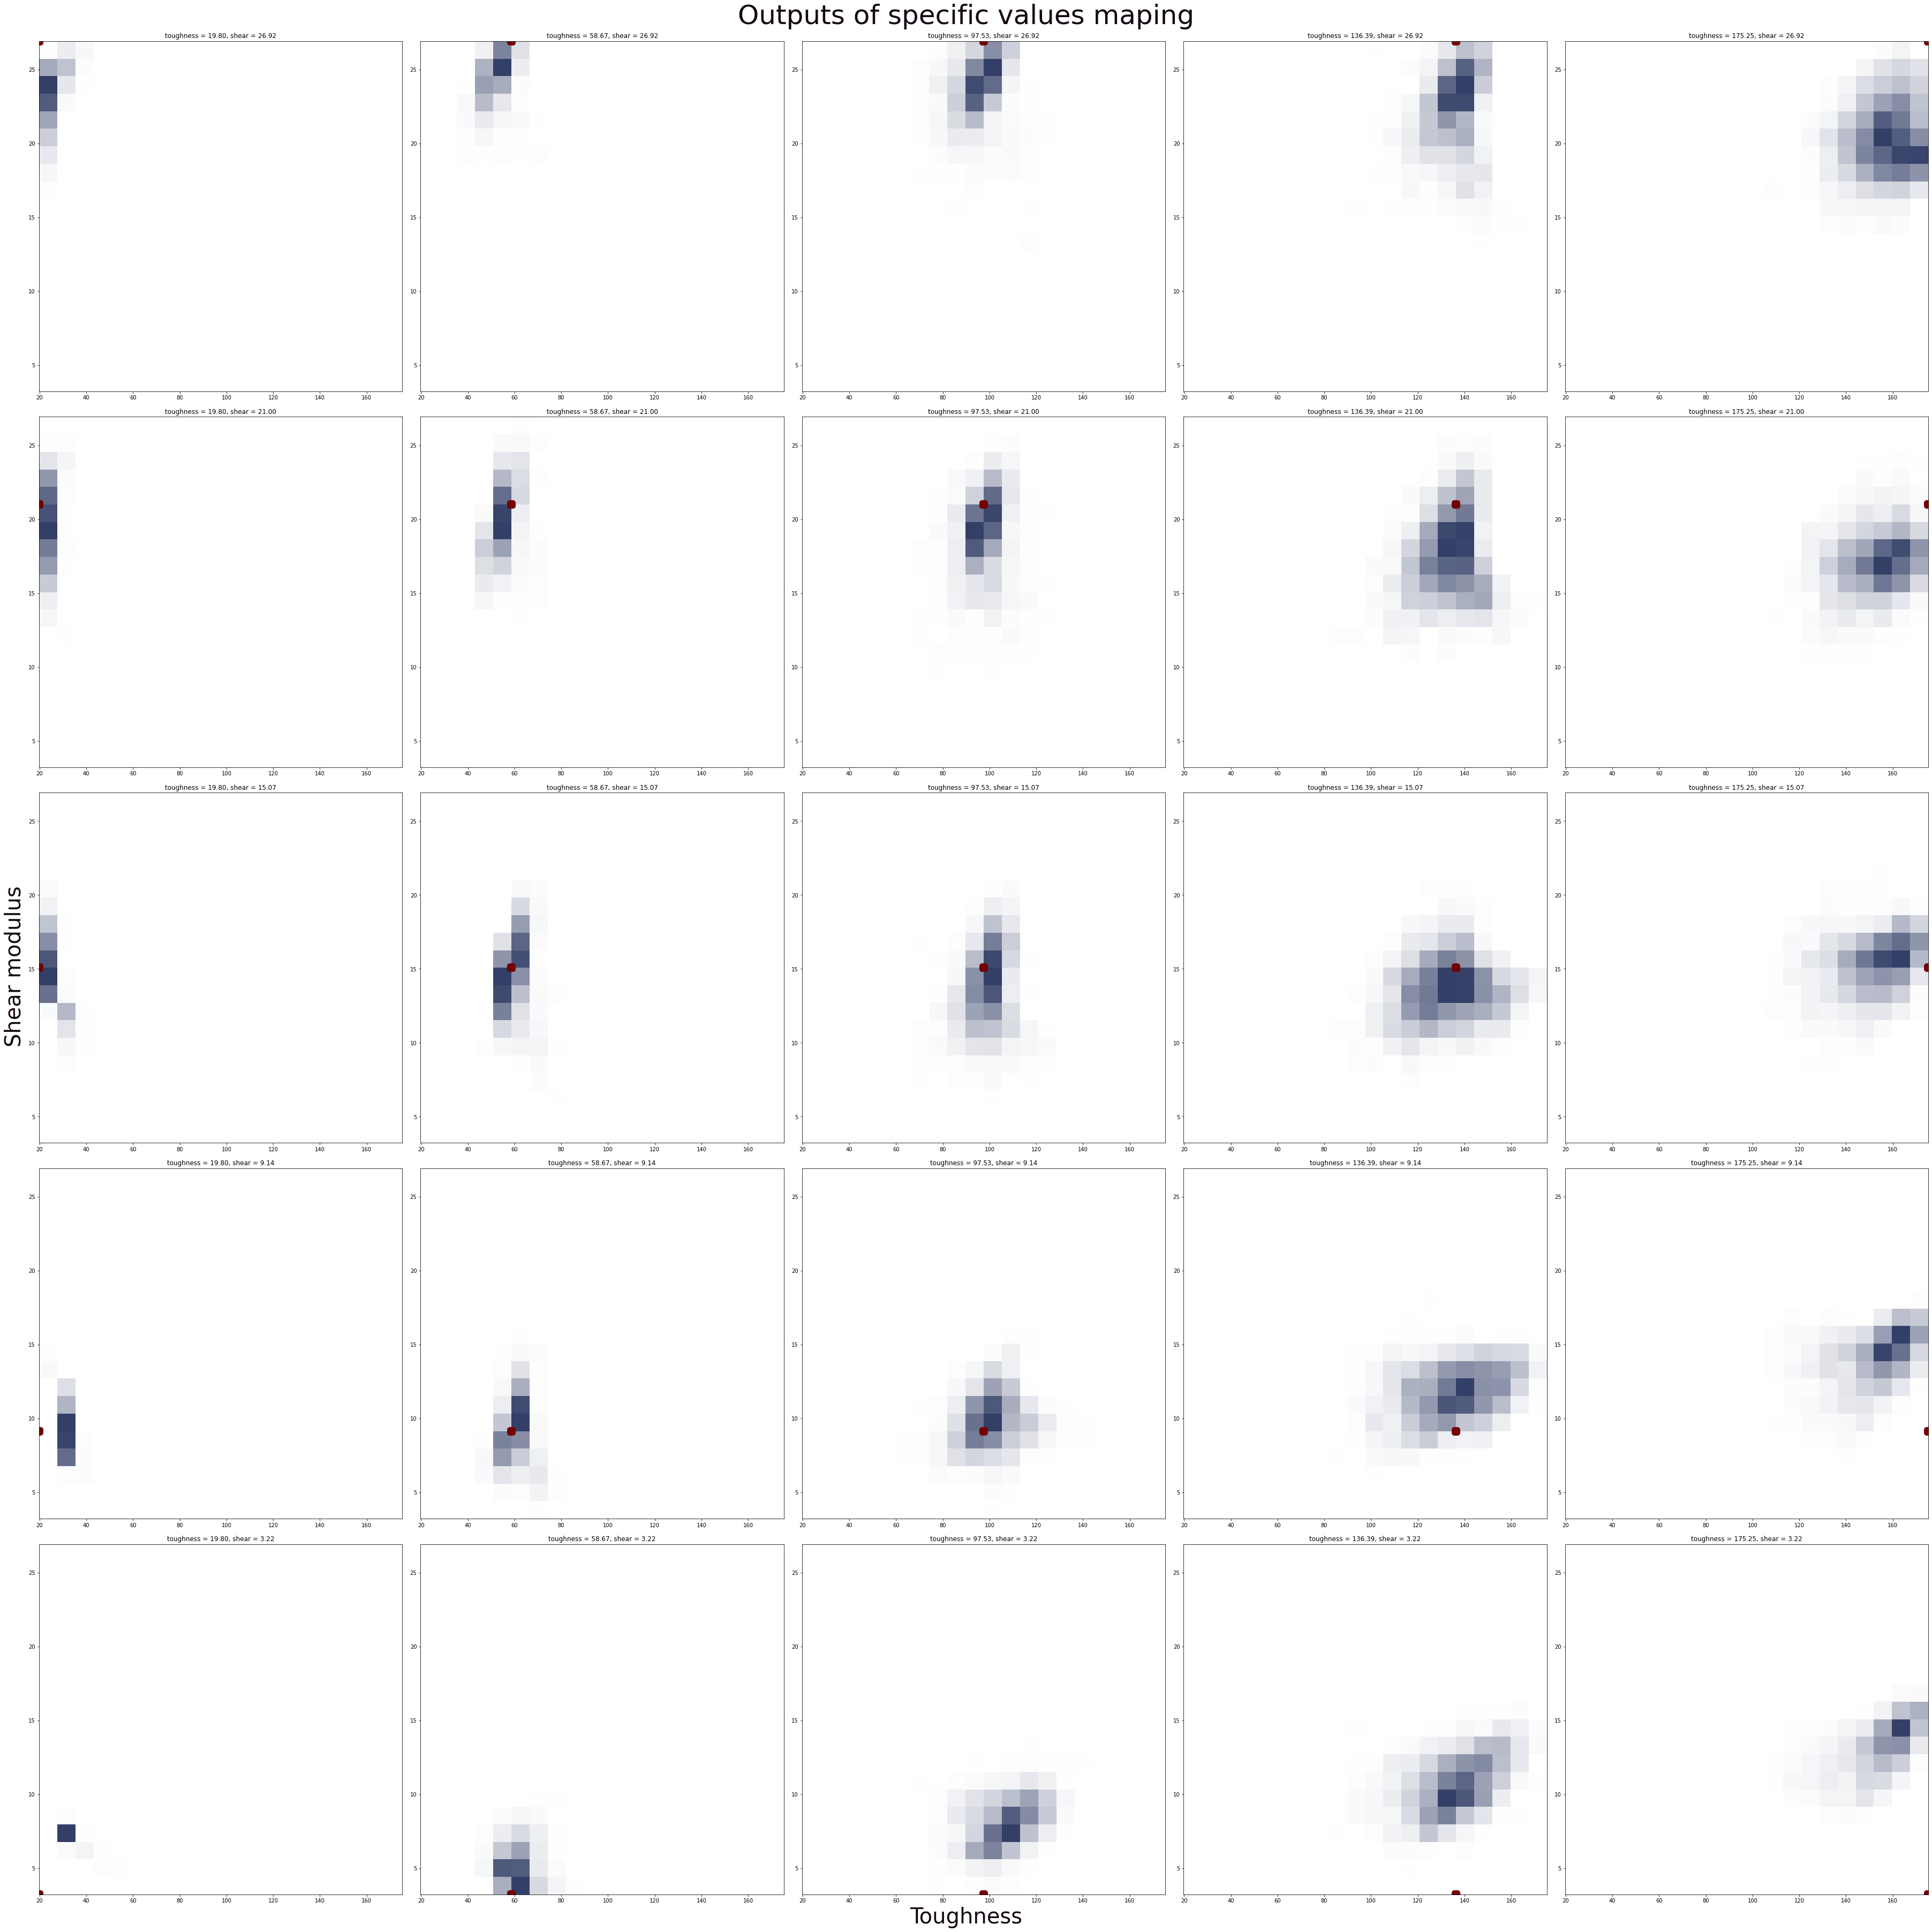

In [11]:
Mappingplot=plotting.output_variance_map(properties_values,latent_mean_std_collection_cAE,scaler,surrogate_model,cAE)

## Violint plots

In [12]:
preprocess_data = vg.preprocess_for_violinplot(properties_values=properties_values,Scaler=scaler,latent_mean_std=latent_mean_std_collection_cAE,over_value=[0,0])
violin_plot_cAE =plotting.violin_plot(surrogate_model=surrogate_model,model=cAE,Scaler=scaler,preprocess_data=preprocess_data)

In [22]:
def create_latentcode_AE(rows,latent_mean_std,latent_dim=5):
  # Create sets of normal distribution latent code within latent mean std range.
  # example: rows = 2000
  latent_output = np.zeros((rows,latent_dim))
  for j in range(5):
    latent_output[:,j] = np.random.normal(latent_mean_std[j][0],latent_mean_std[j][1],rows)
  return torch.from_numpy(latent_output).float()

def create_target_ys(rows,toughness_value,shear_value):
  """This function is the function to create sets(rows) of y label"""
  # example: rows = 2000
  target_ys = np.zeros((rows,2))
  for i in range(rows):
    target_ys[i] = np.array([toughness_value,shear_value])
  return target_ys


def preprocess_for_violinplot_AE(properties_values,Scaler,latent_mean_std,AE_model,surrogate_model,latent_dim = 5,interpolation = 20):
    #Decide the value want to explore 
    input_toughness = np.linspace(properties_values[:,0].min(),properties_values[:,0].max(),20)
    input_shear = np.linspace(properties_values[:,1].min(),properties_values[:,1].max(),20)
    #Create latent code and condition code
    latent_code = create_latentcode_AE(2000,latent_mean_std,latent_dim=latent_dim)
    # ys_collection = torch.zeros((20,2000,2))
    # ys_temporary = np.zeros((2000,2))
    # for i in range(20):
    #   ys_temporary = torch.tensor(Scaler.transform(create_target_ys(2000,input_toughness[i],input_shear[i]))).float()
    #   ys_collection[i] = ys_temporary

    surr_value = np.zeros((2,2000,interpolation))

    for i in range(20):
        cond = create_target_ys(2000,input_toughness[i],input_shear[i])
        cond = Scaler.transform(cond)
        cond = torch.tensor(cond).float()
        recipes = AE_model.decode(latent_code,cond)
        surr_res = Scaler.inverse_transform(surrogate_model(recipes).detach().numpy())
        surr_value[0,:,i] = surr_res[:,0]
        surr_value[1,:,i] = surr_res[:,1]
        # surr_value[i] = Scaler.inverse_transform(surr_value[i])
    return surr_value,[input_toughness,input_shear]

def violin_plot_beta(collected_data,collected_conds):
  #collected data in shape with (2, 2000, 20)
  #pick shear modulus or toughness
  #Over_value can offer the way to explore the properties out of the range
  #Violin plot (data,objects) (2000,20)

  properties_name=["toughness","shear modulus"]
  #calculate mean
  def calculate_mean(outputproperties):
    meandata = np.zeros((2,20))
    for i in range(20):
      meandata[0][i]= outputproperties[0,:,i].mean()
      meandata[1][i]= outputproperties[1,:,i].mean()
    return meandata

  mean_data = calculate_mean(collected_data)

  #Plotting violin plot
  fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(200,100),constrained_layout=True)
  fig.set_facecolor(colorformat["background"])
  # fig.suptitle("Outputs of specific values maping",color=colorformat["text"],fontsize=200)
  for i in range(2):
    if i == 0:
      w=3
    else:
      w=0.5 
    violin = axes[i].violinplot(collected_data[i],collected_conds[i],widths=w,showextrema=False,showmeans=False)
    for pc in violin['bodies']:
      pc.set_facecolor(colorformat['bar'])
      pc.set_edgecolor(colorformat['line'])
      pc.set_alpha(1)
    axes[i].grid(visible=True,linewidth=2)
    axes[i].set_facecolor(colorformat["background"])
    axes[i].set_xlabel("setting",fontsize=120)
    axes[i].set_ylabel("generated and expected",fontsize=120)
    axes[i].set_title(properties_name[i],fontsize=150)
    axes[i].plot(collected_conds[i],mean_data[i],c=colorformat["Highlight"],linewidth=20,label="generated")
    axes[i].plot(collected_conds[i],collected_conds[i],"--",c=colorformat["Highlight"],linewidth=20,label="expected")
    axes[i].legend(fontsize=150,loc=2)

  return fig

collected_data,collected_conds = preprocess_for_violinplot_AE(properties_values,scaler,latent_mean_std_collection_cAE,cAE,surrogate_model)
_ = violin_plot_beta(collected_data,collected_conds)

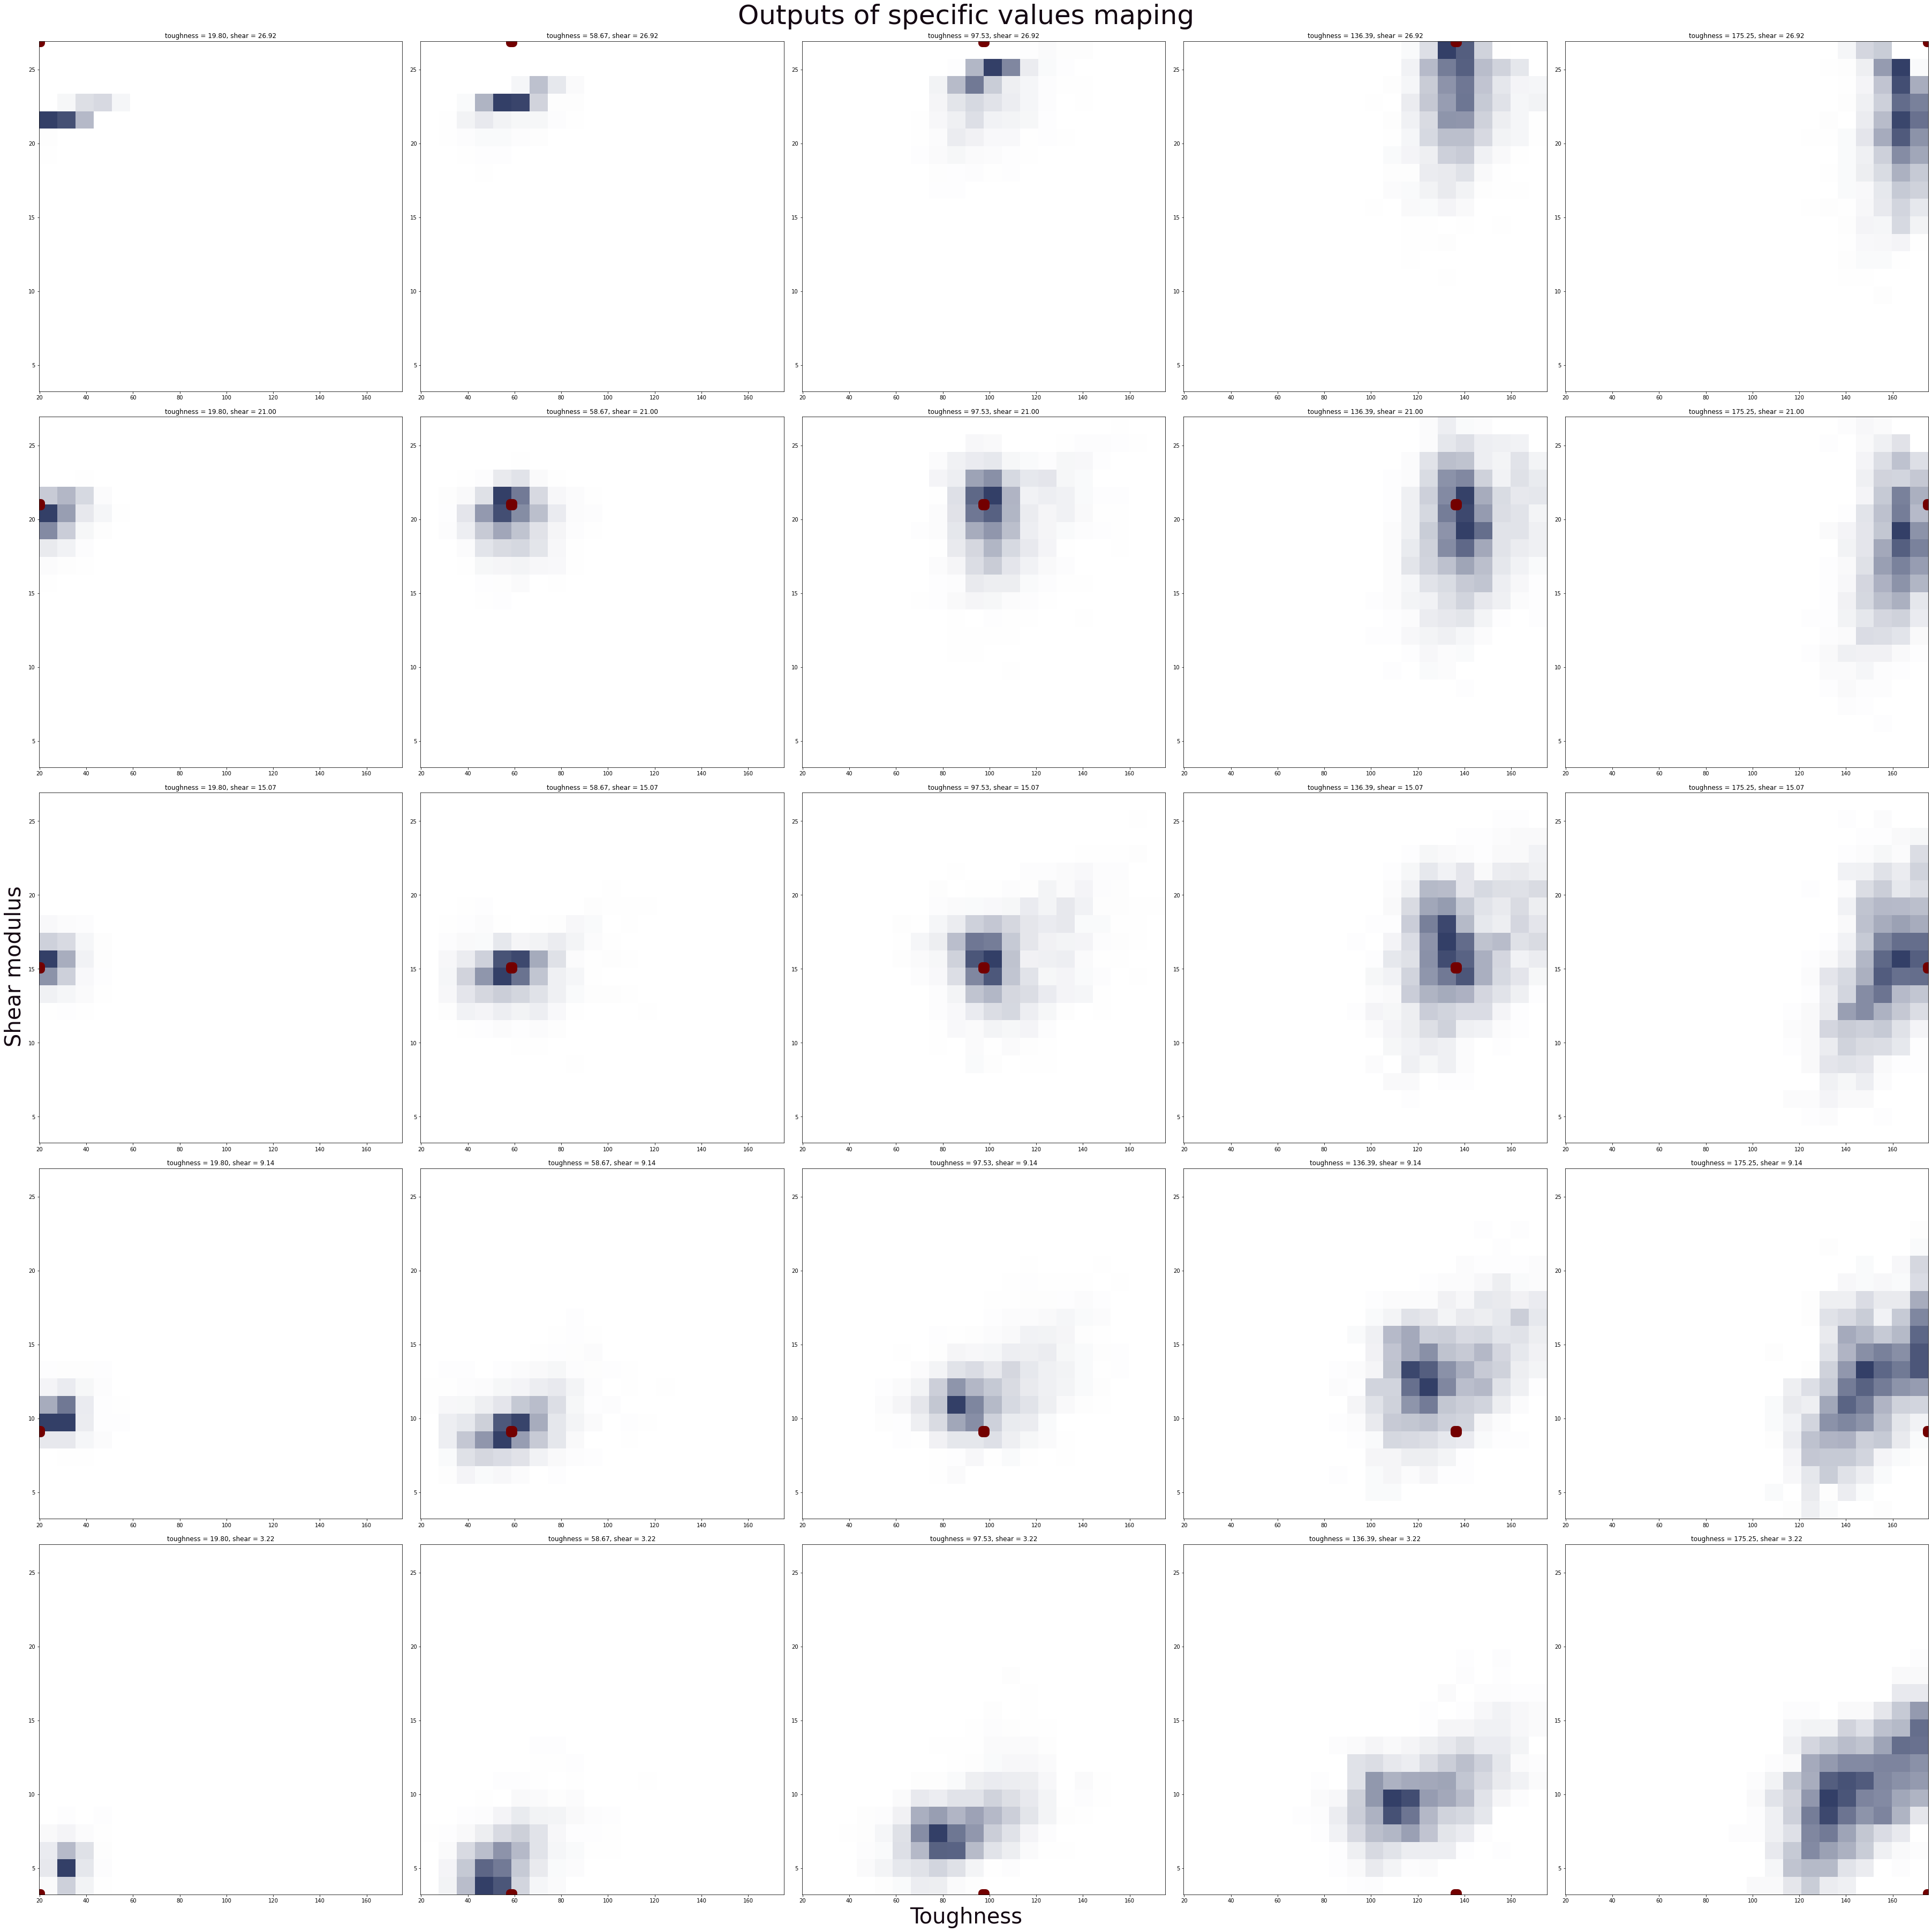

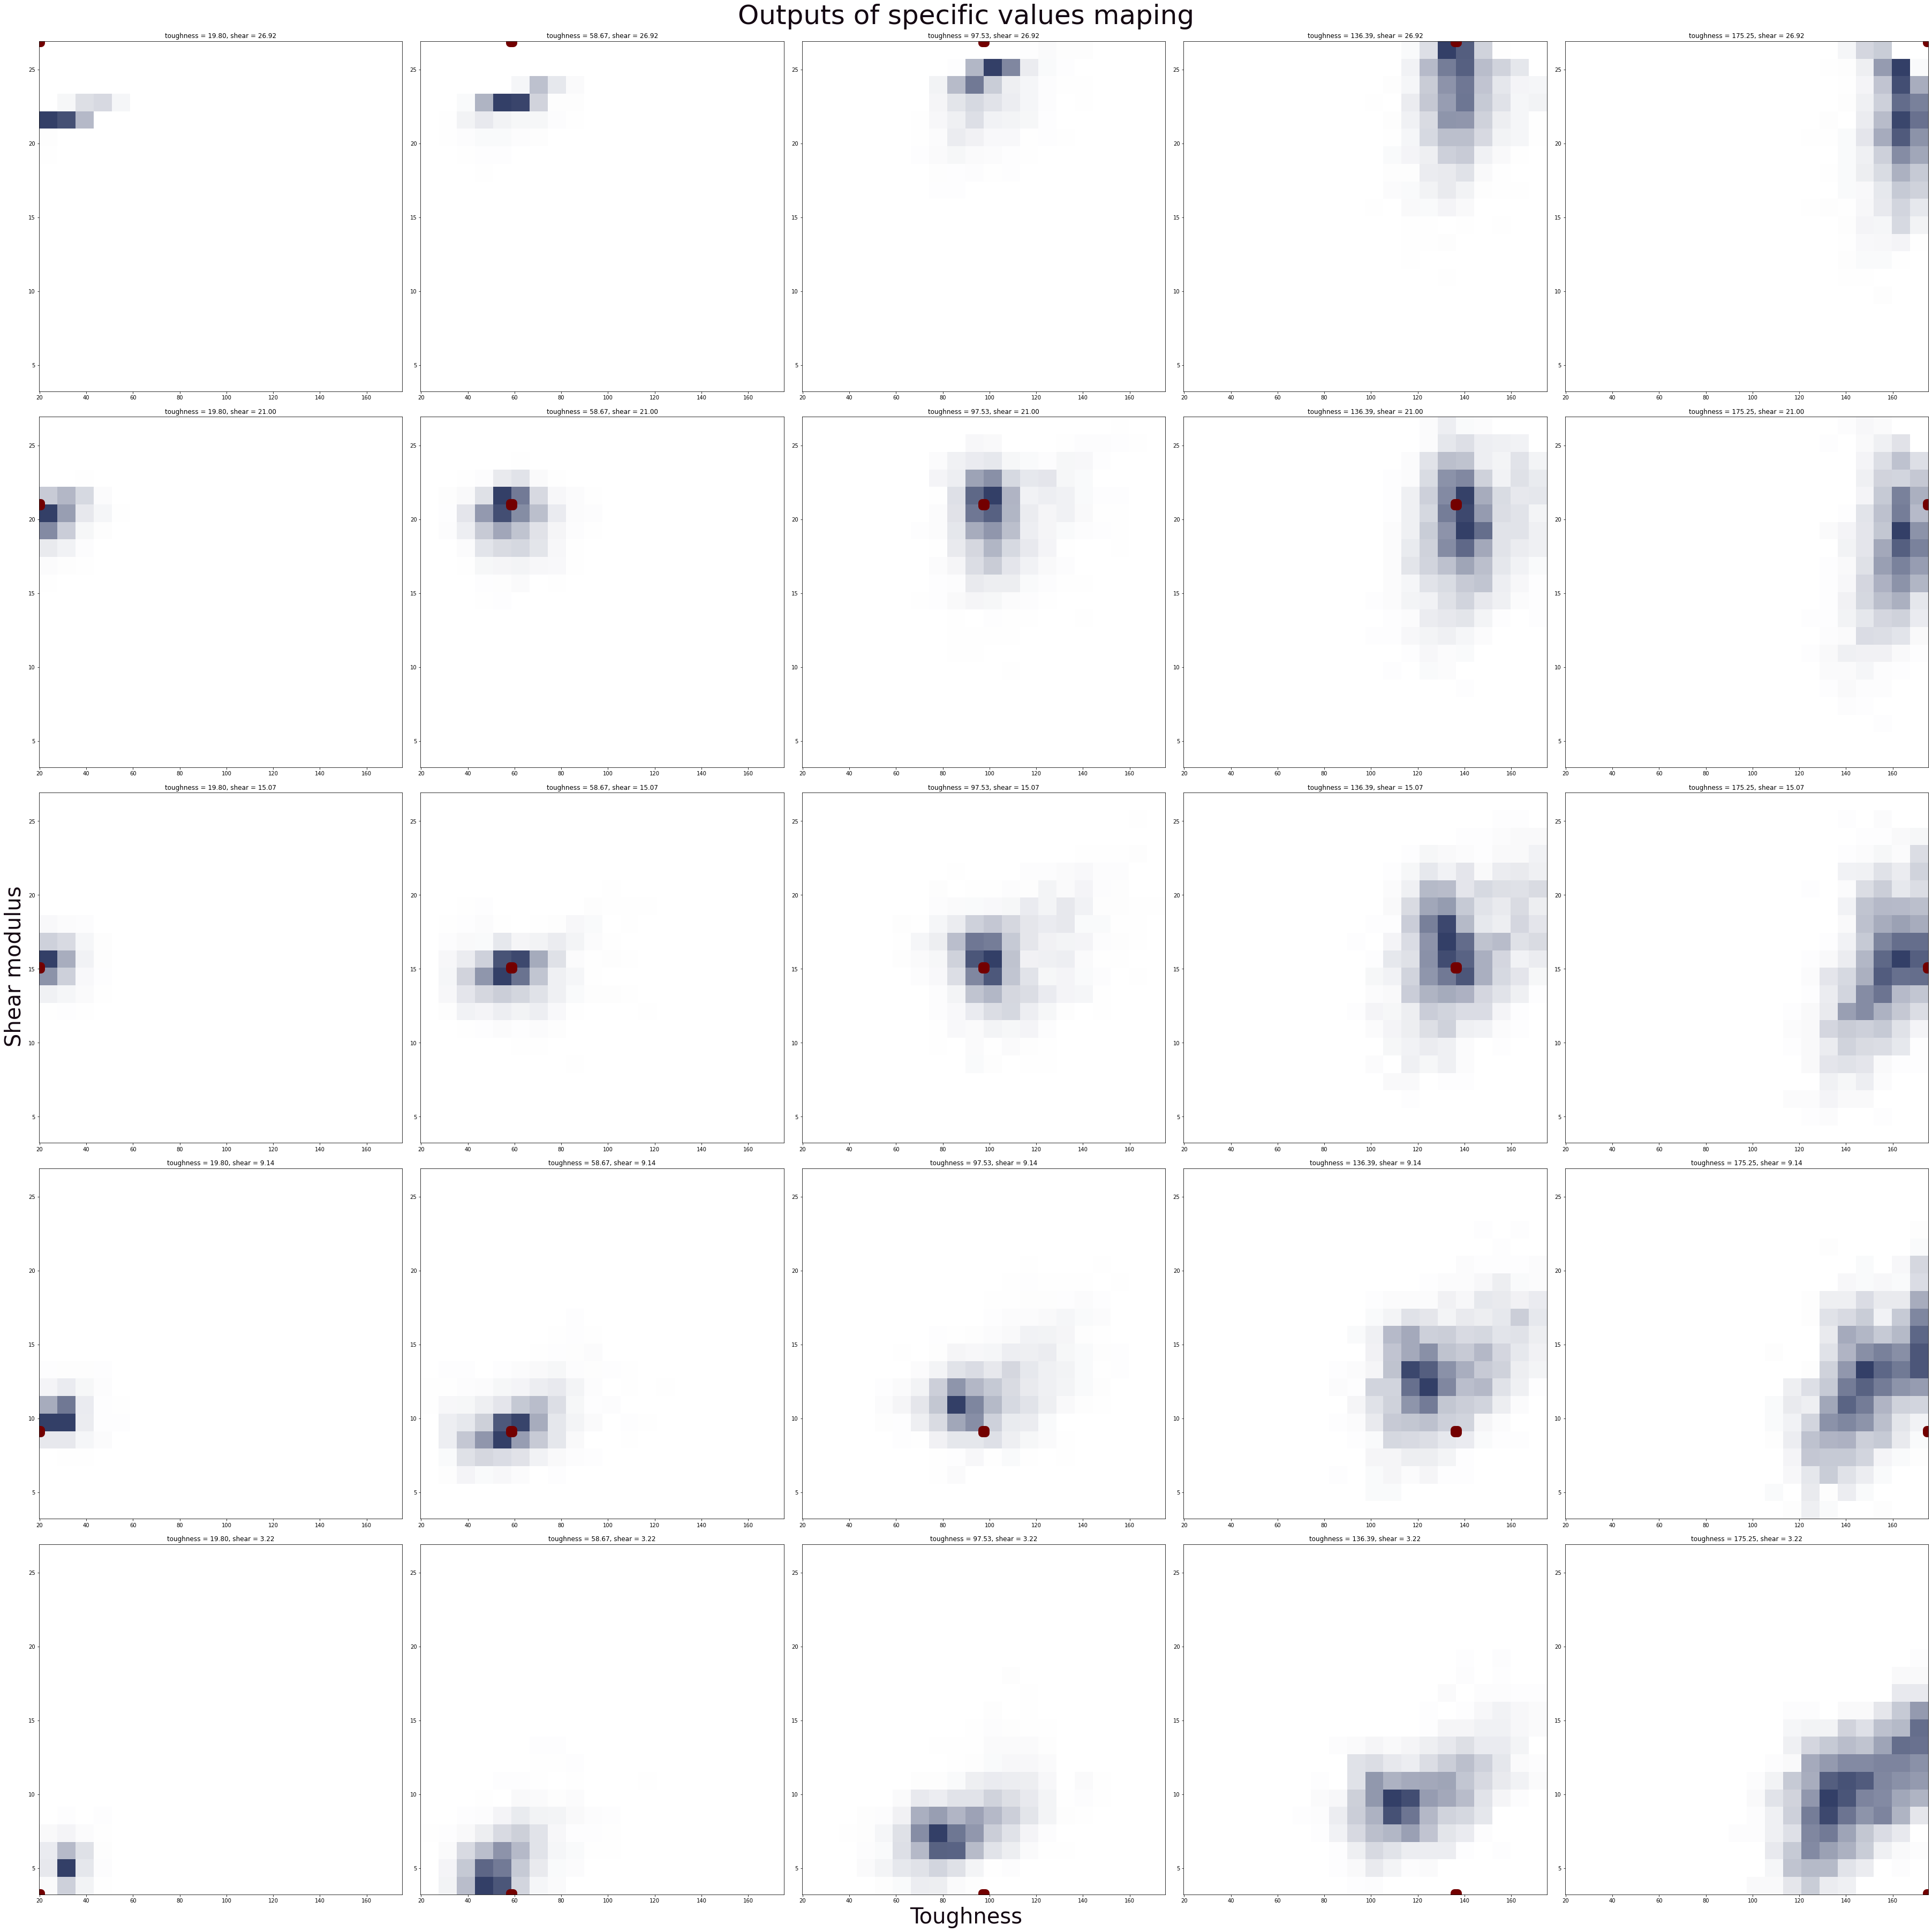

In [26]:


def preprocess_variance_map_AE(properties_values,latent_mean_std_collection,Scaler,AE,surrogate_model,interpolation = 5):
  #latent code setting
  latent_code = latent_value=create_latentcode_AE(2000,latent_mean_std_collection)

  # conditions setting
  input_toughness = np.linspace(properties_values[:,0].min(),properties_values[:,0].max(),interpolation)
  input_shear = np.linspace(properties_values[:,1].max(),properties_values[:,1].min(),interpolation)

  surr_value = np.zeros((interpolation*interpolation,2000,2))
  count = 0
  for i in range (interpolation):
      for j in range(interpolation):
          cond = create_target_ys(2000,input_toughness[i],input_shear[j])
          cond = Scaler.transform(cond)
          cond = torch.tensor(cond).float()
          recipes = AE.decode(latent_code,cond)
          surr_value[count] = surrogate_model(recipes).detach().numpy()
          surr_value[count] = Scaler.inverse_transform(surr_value[count])
          count += 1
  return surr_value,[input_toughness,input_shear]

def variance_map_beta(forim,inter_cond,interpolation=5):
    fig,axes = plt.subplots(interpolation,interpolation,figsize=(50,50),constrained_layout=True)
    fig.set_facecolor(colorformat["background"])
    fig.supxlabel("Toughness",color=colorformat["text"],fontsize=40)
    fig.supylabel("Shear modulus",color=colorformat["text"],fontsize=40)
    fig.suptitle("Outputs of specific values maping",color=colorformat["text"],fontsize=50)
    # forim,inter_cond = preprocess_variance_map(properties_values,scaler,WcGAN,surrogate_model)
    count = 0
    for i in range(interpolation): #shear
        for j in range(interpolation): #toughness
            axes[j][i].hist2d(forim[count,:,0],forim[count,:,1],bins=20,range=np.array([[inter_cond[0].min(),inter_cond[0].max()],[inter_cond[1].min(),inter_cond[1].max()]]),cmap=cmap_format) #Blues
            axes[j][i].scatter(inter_cond[0][i],inter_cond[1][j],marker = 's',color =colorformat["Highlight"],linewidths = 15)
            axes[j][i].set_title('toughness = {t:.2f}, shear = {s:.2f}'.format(t=inter_cond[0][i],s=inter_cond[1][j]))
            count += 1
    return fig

PP1, PP2 = preprocess_variance_map_AE(properties_values,latent_mean_std_collection_cAE,scaler,cAE,surrogate_model)
variance_map_beta(PP1,PP2)